In [1]:
from random import sample 
import pandas as pd
import numpy as np
from numpy import linalg as LA
from scipy.special import softmax
import multiprocessing
import networkx as nx
from networkx.algorithms import bipartite
from networkx.algorithms import matching
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import itertools
import os
import re
import sys
import pickle
import time
import sklearn.decomposition # PCA
import sklearn.manifold # MDS, t-SNEimport phate
import phate # PHATE
import umap # UMAP
import numba
from mpl_toolkits.mplot3d import Axes3D

/home/wayneyw/anaconda3/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


## Simulation points on a simplex and transform to a sphere

In [2]:
# simulate correlated points on a simplex by random-walk
def sim_cor_simplex(n=100,p=100,sigma=2,x0=np.random.randn(100),drift=np.zeros(100)):
    x = x0
    X = []
    X.append(softmax(x))
    for i in np.arange(n-1):
        x = np.random.multivariate_normal(x+drift,(sigma**2)*np.identity(p))
        X.append(softmax(x))
        
    return np.array(X)

### AR with same starting mean w/o drift 

In [65]:
# simulate 10 classes of points
# start with the same point
# random walk with different sigma
p = 100
n = 100
nclass = 10
x0 = np.random.randn(p)
X = []
for c in range(nclass):
    sigma = np.random.normal(loc=1)
    X_tmp = sim_cor_simplex(n=n,p=p,sigma=sigma,x0=x0)
    X.append(np.sqrt(X_tmp))

In [66]:
X = np.vstack(X)

In [67]:
X.shape

(1000, 100)

In [68]:
labs = np.array([[c]*n for c in range(nclass)]).flatten()

In [69]:
len(labs)

1000

### AR with different starting mean w/ drift

In [91]:
# simulate 10 classes of points
# start with diffrent point - different means
# AR with the same variance
# AR with drift: x(t+1) = c + x(t) + epsilon(t)
p = 100
n = 100
nclass = 10
sigma = np.random.normal(loc=0)
X = []
for c in range(nclass):
    x0 = np.random.multivariate_normal(np.ones(p)*c,np.identity(p))
    X_tmp = sim_cor_simplex(n=n,p=p,sigma=sigma,x0=x0,drift=np.ones(p)*c)
    X.append(np.sqrt(X_tmp))

In [92]:
X = np.vstack(X)
X.shape

(1000, 100)

In [93]:
labs = np.array([[c]*n for c in range(nclass)]).flatten()

In [94]:
len(labs)

1000

### Plot the sphere (for 3-dim data only)

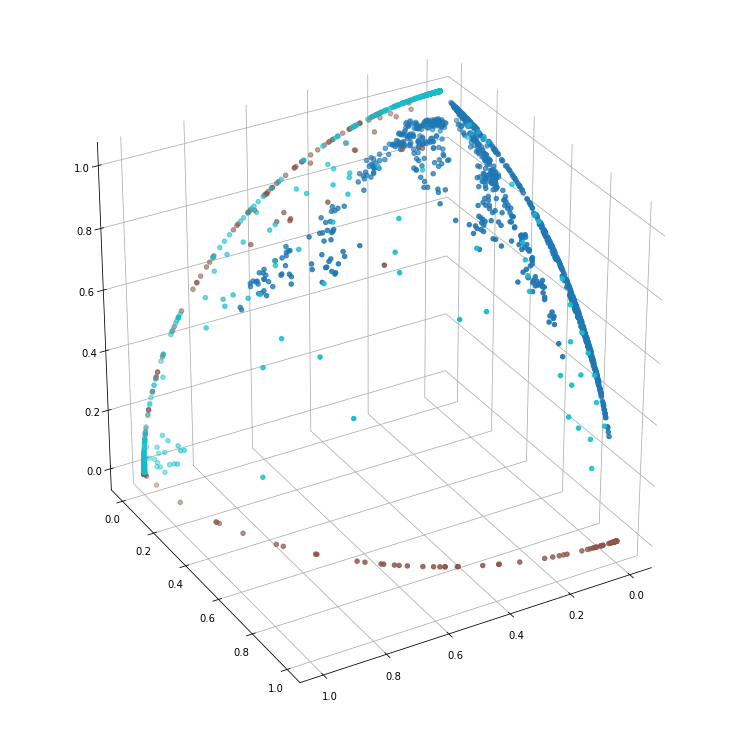

In [384]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.scatter(X[:,0],X[:,1],X[:,2],c=labs,cmap="tab10")
ax.view_init(30, 60)
# plt.show()
# plt.savefig("../../twitter-covid-report/hellinger-sphere-demo-3d.png")

## Embed the sphere to 2D

### Compute Hellinger distance matrix

In [95]:
@numba.njit()
def hellinger(p,q):
    return np.linalg.norm(np.sqrt(p)-np.sqrt(q))/np.sqrt(2)

In [96]:
N = len(labs)
hellinger_dist = np.empty((N,N))
for i in range(N):
    for j in range(N):
        p = X[i,:]
        q = X[j,:]
        hellinger_dist[i,j] = hellinger(p,q)

In [97]:
hellinger_dist.shape

(1000, 1000)

In [98]:
start = time.time()
pca_operator = sklearn.decomposition.PCA(n_components=2)
embed_pca = pca_operator.fit_transform(X)
end = time.time()
print("Embedded PCA in {:.2f} seconds.".format(end-start))

# start = time.time()
# mds_operator = sklearn.manifold.MDS(n_components=2, metric=True, dissimilarity="precomputed", n_jobs=-2)
# embed_mds = mds_operator.fit_transform(hellinger_dist)
# end = time.time()
# print("Embedded MDS in {:.2f} seconds.".format(end-start))

start = time.time()
tsne_operator = sklearn.manifold.TSNE(n_components=2, metric="precomputed")
embed_tsne = tsne_operator.fit_transform(hellinger_dist)
end = time.time()
print("Embedded t-SNE in {:.2f} seconds.".format(end-start))

start = time.time()
umap_operator = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.25, metric="hellinger")
embed_umap = umap_operator.fit_transform(X)
end = time.time()
print("Embedded UMAP in {:.2f} seconds.".format(end-start))

start = time.time()
phate_operator = phate.PHATE(n_components=2, gamma=0, t=100, knn_dist="precomputed")
embed_phate = phate_operator.fit_transform(hellinger_dist)
end = time.time()
print("Embedded PHATE in {:.2f} seconds.".format(end-start))

Embedded PCA in 0.01 seconds.
Embedded t-SNE in 3.56 seconds.
Embedded UMAP in 3.99 seconds.
Calculating PHATE...
  Running PHATE on precomputed distance matrix with 1000 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.10 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.89 seconds.
Calculated PHATE in 1.08 seconds.
Embedded PHATE in 1.08 seconds.


<ipython-input-100-f2d92291e838>:5: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(embed_pca, label_prefix="PC", s=10,
<ipython-input-100-f2d92291e838>:15: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(embed_tsne, label_prefix="t-SNE", s=10,
<ipython-input-100-f2d92291e838>:20: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(embed_umap, label_prefix="UMAP", s=10,
<ipython-input-100-f2d92291e838>:25: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(embed_phate, label_prefix="PHATE", s=10,


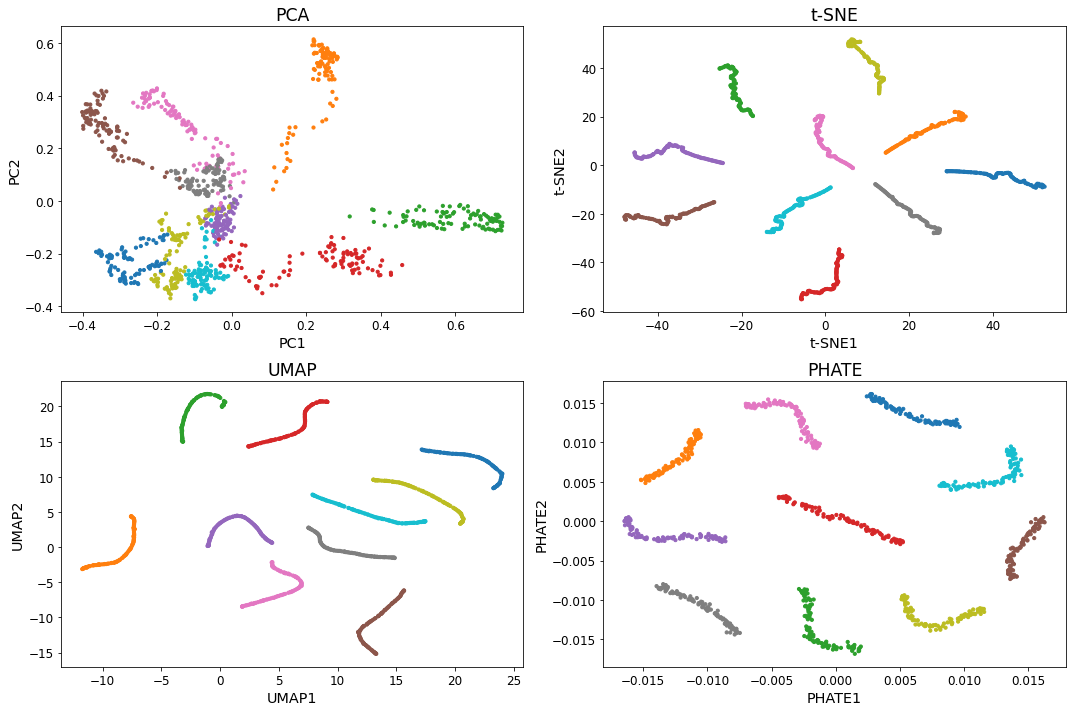

In [100]:
f, axes = plt.subplots(2,2,figsize=(15,10))
ax1, ax2, ax3, ax4 = axes.ravel()

#plotting PCA
phate.plot.scatter2d(embed_pca, label_prefix="PC", s=10, 
                     c=labs, title="PCA", 
                     legend=False, ax=ax1)

# #plotting metric MDS
# phate.plot.scatter2d(embed_mds, label_prefix="MDS", s=10, 
#                      c=labs, title="Metric MDS", 
#                      legend=False, ax=ax2)

#plotting tSNE
phate.plot.scatter2d(embed_tsne, label_prefix="t-SNE", s=10, 
                     c=labs, title="t-SNE", 
                     legend=False, ax=ax2)

#plotting UMAP
phate.plot.scatter2d(embed_umap, label_prefix="UMAP", s=10, 
                     c=labs, title="UMAP", 
                     legend=False, ax=ax3)

#plotting PHATE
phate.plot.scatter2d(embed_phate, label_prefix="PHATE", s=10, 
                     c=labs, title="PHATE", 
                     legend=False, ax=ax4)


# ax6.set_axis_off() #hide unused axis

plt.tight_layout()
# plt.show()
# plt.savefig("../../twitter-covid-report/phate-hellinger-demo-ar-drift.png")

## Simulation random (no trajectory) data

In [85]:
# generate random data from Gaussian mixture
def sim_gmm(n,p,w=[0.6,0.3,0.1]):
    k = len(w)
    X = []
    labs = []
    mu = [np.random.randn(p) for i in range(k)]
    sigma = np.identity(p)
    for i in range(n):
        c = np.random.choice(a=np.arange(k), p=w)
        labs.append(c)
        X.append(softmax(np.random.multivariate_normal(mu[c],sigma))) # transform to probs
        
    return labs, np.array(X) # an n by p array

In [86]:
labs, X = sim_gmm(3000,10)

In [87]:
X.shape

(3000, 10)

In [88]:
@numba.njit()
def hellinger(p,q):
    return np.linalg.norm(np.sqrt(p)-np.sqrt(q))/np.sqrt(2)

In [89]:
N = len(labs)
hellinger_dist = np.empty((N,N))
for i in range(N):
    for j in range(N):
        p = X[i,:]
        q = X[j,:]
        hellinger_dist[i,j] = hellinger(p,q)

### Embed on 2D

In [90]:
start = time.time()
pca_operator = sklearn.decomposition.PCA(n_components=2)
embed_pca = pca_operator.fit_transform(X)
end = time.time()
print("Embedded PCA in {:.2f} seconds.".format(end-start))

# start = time.time()
# mds_operator = sklearn.manifold.MDS(n_components=2, metric=True, dissimilarity="precomputed")
# embed_mds = mds_operator.fit_transform(hellinger_dist)
# end = time.time()
# print("Embedded MDS in {:.2f} seconds.".format(end-start))

start = time.time()
tsne_operator = sklearn.manifold.TSNE(n_components=2, metric="precomputed")
embed_tsne = tsne_operator.fit_transform(hellinger_dist)
end = time.time()
print("Embedded t-SNE in {:.2f} seconds.".format(end-start))

start = time.time()
umap_operator = umap.UMAP(n_components=2, n_neighbors=5, metric=hellinger)
embed_umap = umap_operator.fit_transform(X)
end = time.time()
print("Embedded UMAP in {:.2f} seconds.".format(end-start))

start = time.time()
phate_operator = phate.PHATE(n_components=2, t=1, knn_dist="precomputed")
embed_phate = phate_operator.fit_transform(hellinger_dist)
end = time.time()
print("Embedded PHATE in {:.2f} seconds.".format(end-start))

Embedded PCA in 0.01 seconds.
Embedded t-SNE in 19.71 seconds.


/Users/wayneyw/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1495: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


Embedded UMAP in 9.48 seconds.
Calculating PHATE...
  Running PHATE on precomputed distance matrix with 3000 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
    Calculated affinities in 0.40 seconds.
  Calculated graph and diffusion operator in 0.59 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.59 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.13 seconds.
  Calculated landmark operator in 15.07 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.05 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 9.52 seconds.
Calculated PHATE in 25.25 seconds.
Embedded PHATE in 25.25 seconds.


/Users/wayneyw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  import sys
/Users/wayneyw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
/Users/wayneyw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
/Users/wayneyw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.


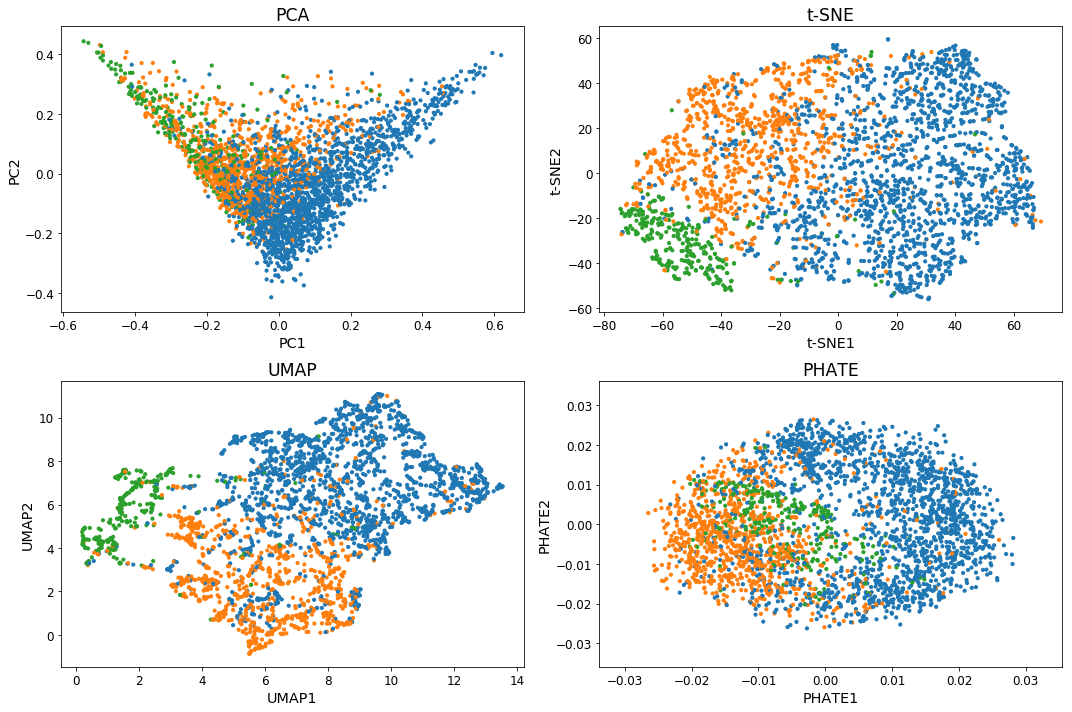

In [92]:
f, axes = plt.subplots(2,2,figsize=(15,10))
ax1, ax2, ax3, ax4 = axes.ravel()

#plotting PCA
phate.plot.scatter2d(embed_pca, label_prefix="PC", s=10, 
                     c=labs, title="PCA", 
                     legend=False, ax=ax1)

# #plotting metric MDS
# phate.plot.scatter2d(embed_mds, label_prefix="MDS", s=10, 
#                      c=labs, title="Metric MDS", 
#                      legend=False, ax=ax2)

#plotting tSNE
phate.plot.scatter2d(embed_tsne, label_prefix="t-SNE", s=10, 
                     c=labs, title="t-SNE", 
                     legend=False, ax=ax2)
#plotting UMAP
phate.plot.scatter2d(embed_umap, label_prefix="UMAP", s=10, 
                     c=labs, title="UMAP", 
                     legend=False, ax=ax3)

#plotting PHATE
phate.plot.scatter2d(embed_phate, label_prefix="PHATE", s=10, 
                     c=labs, title="PHATE", 
                     legend=False, ax=ax4)

# ax6.set_axis_off() #hide unused axis

plt.tight_layout()
# plt.show()
# plt.savefig("../../twitter-covid-report/phate-random-no-traj.png")